# Phân cụm bằng giải thuật K-Means trên bộ dữ liệu chữ số viết tay

Nguồn [A demo of K-Means clustering on the handwritten digits data](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py)

Tham khảo thêm về các giải thuật phân cụm [Clustering](https://scikit-learn.org/stable/modules/clustering.html)

Trong ví dụ này chúng ta thực hiện phân cụm các ảnh chữ số viết tay bằng thuật toán K-Means. Thực nghiệm được tiến hành với các chiến lược khởi tạo khác nhau, qua đó so sánh thời gian chạy cũng như chất lượng của kết quả phân cụm của các chiến lược này.

Các kết quả sẽ được đánh giá trên các độ đo chất lượng phân cụm khác nhau. (tham khảo về các độ đo đánh giá chất lượng phân cụm [Clustering performance evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)

<table class="docutils align-default">
<thead>
<tr class="row-odd"><th class="head"><p>Shorthand</p></th>
<th class="head"><p>full name</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>homo</p></td>
<td><p>homogeneity score</p></td>
</tr>
<tr class="row-odd"><td><p>compl</p></td>
<td><p>completeness score</p></td>
</tr>
<tr class="row-even"><td><p>v-meas</p></td>
<td><p>V measure</p></td>
</tr>
<tr class="row-odd"><td><p>ARI</p></td>
<td><p>adjusted Rand index</p></td>
</tr>
<tr class="row-even"><td><p>AMI</p></td>
<td><p>adjusted mutual information</p></td>
</tr>
<tr class="row-odd"><td><p>silhouette</p></td>
<td><p>silhouette coefficient</p></td>
</tr>
</tbody>
</table>





## Nạp dữ liệu

Bước đầu tiên của thực nghiệm là nạp vào bộ dữ liệu `ditgits`. Bộ dữ liệu này chứa các ảnh chữ số viết tay từ 0 đến 9. Trong ngữ cảnh của việc phân cụm dữ liệu, chúng ta mong muốn rằng có thể phân các ảnh của cùng một chữ số và cùng một cụm.


In [ ]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


## Một số thông tin cơ bản về dữ liệu


*   Kiểu dữ liệu
*   Số lượng
*   Kích thước các chiều
*   1 điểm dữ liệu chứa gì?



In [ ]:
# Một số thông tin về dữ liệu
print(type(data))
print(len(data))
print(data.shape)
print(data[0])
print(data[0].reshape(8,8))
print(labels[0])

<class 'numpy.ndarray'>
1797
(1797, 64)
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]
0


## Hiển thị dữ liệu

Sử dụng thư viện matplotlib để hiển thị một số dữ liệu dưới dạng hình ảnh

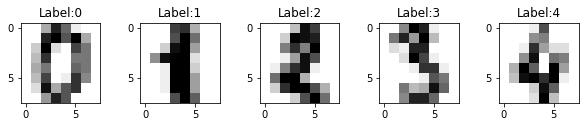

In [ ]:

%matplotlib inline
from matplotlib import pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,10))
for i,ax in enumerate(axs.flatten()):
  plt.sca(ax)
  # ax.set_axis_off()
  plt.imshow(data[i].reshape(8,8),cmap=plt.cm.gray_r, interpolation='nearest')
  plt.title('Label:{}'.format(labels[i]))
plt.subplots_adjust(wspace= 0.5,hspace= 0.5)
plt.show()

## Đánh giá

Việc đánh giá giữa các phương pháp khởi tạo cho thuật toán K-Means sẽ được thực hiện thông qua việc đo thời gian thực thi của thuật toán, cũng như thông qua đánh giá chất lượng của kết quả phân cụm bằng các độ đo khác nhau.



In [ ]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.505s	69662	0.680	0.719	0.699	0.570	0.695	0.170
random   	0.134s	69707	0.675	0.716	0.694	0.560	0.691	0.174
PCA-based	0.138s	72686	0.636	0.658	0.647	0.521	0.643	0.142
__________________________________________________________________________________


## Minh họa kết quả phân cụm

Mỗi điểm dữ liệu trong data có kích thước là 64, tương ứng với vector trên không gian 64 chiều, sẽ rất khó để minh họa dữ liệu trên chiều không gian lớn như vậy. Thay vào đó chúng ta sẽ sử dụng giải thuật PCA để chiếu dữ liệu từ 64 chiều xuống thành dữ liệu 2 chiều, qua đó chúng ta sẽ dễ dàng hơn trong việc mô phỏng kết quả phân cụm bằng hình ảnh

[[1 1 1 ... 9 9 9]
 [1 1 1 ... 9 9 9]
 [1 1 1 ... 9 9 9]
 ...
 [6 6 6 ... 0 0 0]
 [6 6 6 ... 0 0 0]
 [6 6 6 ... 0 0 0]]


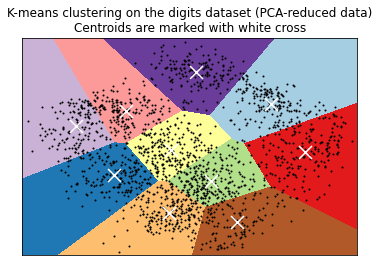

In [ ]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.01  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
print(Z)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


# Ví dụ về bài toán phân lớp chữ số viết tay

Trong ví dụ này, chúng ta sử dụng mô hình phân lớp SVM để nhận dạng chữ số viết tay. (Tham khảo về SVM [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html))





## Nạp dữ liệu

Về cơ bản thì các bước xử lý ban đầu với dữ liệu của ví dụ này cũng giống như với ví dụ trước.

# digits: 10; # samples: 1797; # features 64
<class 'numpy.ndarray'>
1797
(1797, 64)
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


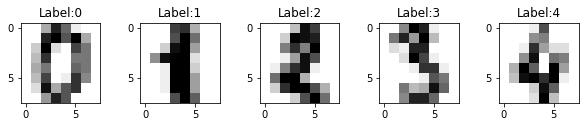

In [ ]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# Một số thông tin về dữ liệu
print(type(data))
print(len(data))
print(data.shape)
print(data[0])
print(data[0].reshape(8,8))


# Hiển thị hình ảnh của 1 số dữ liệu
%matplotlib inline
from matplotlib import pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,10))
for i,ax in enumerate(axs.flatten()):
  plt.sca(ax)
  # ax.set_axis_off()
  plt.imshow(data[i].reshape(8,8),cmap=plt.cm.gray_r, interpolation='nearest')
  plt.title('Label:{}'.format(labels[i]))
plt.subplots_adjust(wspace= 0.5,hspace= 0.5)
plt.show()

## Xây dựng bộ phân lớp dùng SVM
Từ bộ dữ liệu gồm các ảnh được lưu dưới dạng mảng 1 chiều X, và nhãn là số của dữ liệu đó Y

Chúng ta sẽ chia bộ dữ liệu thành 2 phần, 1 phần dùng để huấn luyện mô hình phân lớp, phần còn lại dùng để kiểm tra hiệu suất của mô hình phân lớp.


In [ ]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.5, shuffle=True
)

clf = svm.SVC(gamma=0.001)
# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)



## Minh họa kết quả dự đoán nhãn


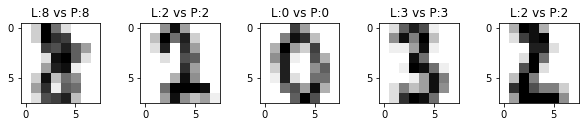

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,10))
for i,ax in enumerate(axs.flatten()):
  plt.sca(ax)
  # ax.set_axis_off()
  plt.imshow(X_test[i].reshape(8,8),cmap=plt.cm.gray_r, interpolation='nearest')
  plt.title('L:{} vs P:{}'.format(y_test[i],predicted[i]))
plt.subplots_adjust(wspace= 0.5,hspace= 0.5)
plt.show()

In [ ]:
# Hiệu quả của mô hình phân lớp theo F1_score

print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.98      1.00      0.99        99
           2       0.99      0.97      0.98        95
           3       1.00      0.94      0.97        89
           4       1.00      1.00      1.00        87
           5       0.98      1.00      0.99        85
           6       1.00      0.98      0.99        87
           7       0.99      1.00      0.99        94
           8       0.92      0.99      0.95        80
           9       0.99      0.97      0.98        94

    accuracy                           0.98       899
   macro avg       0.98      0.98      0.98       899
weighted avg       0.99      0.98      0.98       899




Confusion matrix:
[[89  0  0  0  0  0  0  0  0  0]
 [ 0 99  0  0  0  0  0  0  0  0]
 [ 0  1 92  0  0  0  0  0  2  0]
 [ 0  0  1 84  0  0  0  0  3  1]
 [ 0  0  0  0 87  0  0  0  0  0]
 [ 0  0  0  0  0 85  0  0  0  0]
 [ 0  0  0  0  0  1 85  0  1  0]
 [ 0  0  0  0  0  0  0 94  0  0]
 [ 0  1  0  0  0  0  0  0 79  0]
 [ 0  0  0  0  0  1  0  1  1 91]]


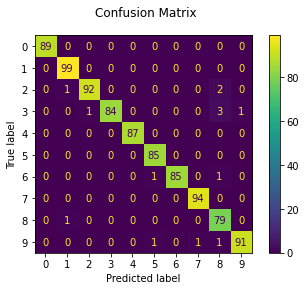

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

# Ví dụ về giải thuật Tiến hóa

Nguồn [Tune Your Scikit-learn Model Using Evolutionary Algorithms](https://towardsdatascience.com/tune-your-scikit-learn-model-using-evolutionary-algorithms-30538248ac16)

Trong ví dụ này, chúng ta sẽ tiến hành thực nghiệm về bài toán nhận dạng chữ viết tay sử dụng mô hình Random Forest.

Để lựa chọn bộ tham số tối ưu cho mô hình phân lớp Random Forest, chúng ta sử dụng giải thuật tiến hóa (Evolutionary Algorithm).

Thư viện sử dụng là `sklearn-genetic-opt `


In [ ]:
!pip install sklearn-genetic-opt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 7.8 MB/s 


In [ ]:
# Khởi tạo bộ phân lớp Dùng mô hình Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score

data = load_digits()

n_samples = len(data.images)
X = data.images.reshape((n_samples, -1))
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

clf = RandomForestClassifier()


## Tinh chỉnh Mô hình phân lớp bằng giải thuật tiến hóa

Chúng ta sử dụng thư viện sklearn-genetic-opt để tinh chỉnh bộ phân lớp dựa trên một độ đo là độ chính xác từ việc kiểm tra chéo (cross-validation).

Param_grid tương tự như scikit-learning, nhưng chúng ta phải sử dụng các lớp không gian để cho sklearn-gene-opt biết loại dữ liệu nào sẽ sử dụng để lấy mẫu các tham số.

Để xác định tùy chọn này và các tùy chọn khác, chúng ta phải sử dụng lớp chính của gói được gọi là GASearchCV.

In [ ]:
#

from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'max_depth': Integer(2, 30),
              'max_leaf_nodes': Integer(2, 35),
              'n_estimators': Integer(100, 300)}

cv = StratifiedKFold(n_splits=3, shuffle=True)

evolved_estimator = GASearchCV(estimator=clf,
                               cv=cv,
                               scoring='accuracy',
                               population_size=10,
                               generations=35,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

## Giải thích các tham số

`estimator`  phải là bộ phân loại hoặc bộ hồi quy sckit-learning, `cv` là số lần phân tách trong xác thực chéo hoặc trình tạo xác thực chéo và `scoring` là độ đo được chọn để tối ưu hóa — nó phải là một trong các độ đo trong `sklearn` tương thích với `estimator`.

Bây giờ chúng ta có thể điều chỉnh mô hình của mình và sử dụng nó trong dữ liệu thử nghiệm, theo mặc định, nó sẽ sử dụng bộ  tham số tốt nhất được tìm thấy:

In [ ]:
evolved_estimator.fit(X_train,y_train)
y_predicy_ga = evolved_estimator.predict(X_test)
accuracy_score(y_test,y_predicy_ga)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.806485	0.0856882  	0.927602   	0.658721   
1  	16    	0.877349	0.0458882  	0.927602   	0.773619   
2  	17    	0.901649	0.0244796  	0.927602   	0.864577   
3  	18    	0.915001	0.0174264  	0.927602   	0.864577   
4  	19    	0.928564	0.00664311 	0.940596   	0.918343   
5  	18    	0.935425	0.00578116 	0.940637   	0.925812   
6  	19    	0.933933	0.00616035 	0.940637   	0.923929   
7  	19    	0.938571	0.00315682 	0.940637   	0.929474   
8  	18    	0.938768	0.004388   	0.940637   	0.925791   
9  	18    	0.940632	0.000830551	0.942468   	0.938754   
10 	18    	0.937102	0.00635206 	0.942468   	0.922057   
11 	19    	0.936196	0.00469554 	0.940637   	0.929557   
12 	17    	0.938603	0.00408819 	0.940637   	0.929557   
13 	18    	0.938221	0.00370754 	0.940637   	0.929557   
14 	16    	0.940454	0.000549348	0.940637   	0.938806   
15 	17    	0.936549	0.0053165  	0.940637   	0.927592   
16 	19    	0.938783	0.0037962  	0.940637   	0.92

0.9379968203497615

Trong khi thuật toán đang chạy, nó cho chúng ta thấy các chỉ số mà nó đạt được ở mỗi thế hệ; "**fitness**" đề cập đến độ đo chúng ta đã chọn, trong trường hợp này là độ chính xác. Vì thuật toán sử dụng nhiều hơn một bộ siêu tham số cho mỗi thế hệ, nó cho thấy độ chính xác trung bình, độ lệch chuẩn và các giá trị tối đa và tối thiểu.

Trong lần chạy cụ thể này, chúng ta nhận được độ chính xác trong bộ thử nghiệm là 0,93 với bộ siêu tham số này:

{'min_weight_fraction_leaf': 0.012281015507535771, 'bootstrap': True, 'max_depth': 26, 'max_leaf_nodes': 32, 'n_estimators': 244}


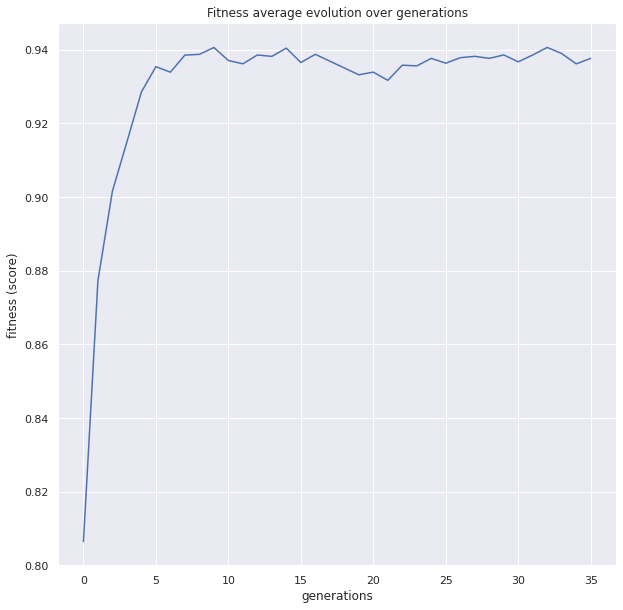

In [ ]:
print(evolved_estimator.best_params_)

plot_fitness_evolution(evolved_estimator)
plt.show()

In [ ]:
print("Parameters and cv score in each iteration")
print(evolved_estimator.logbook)

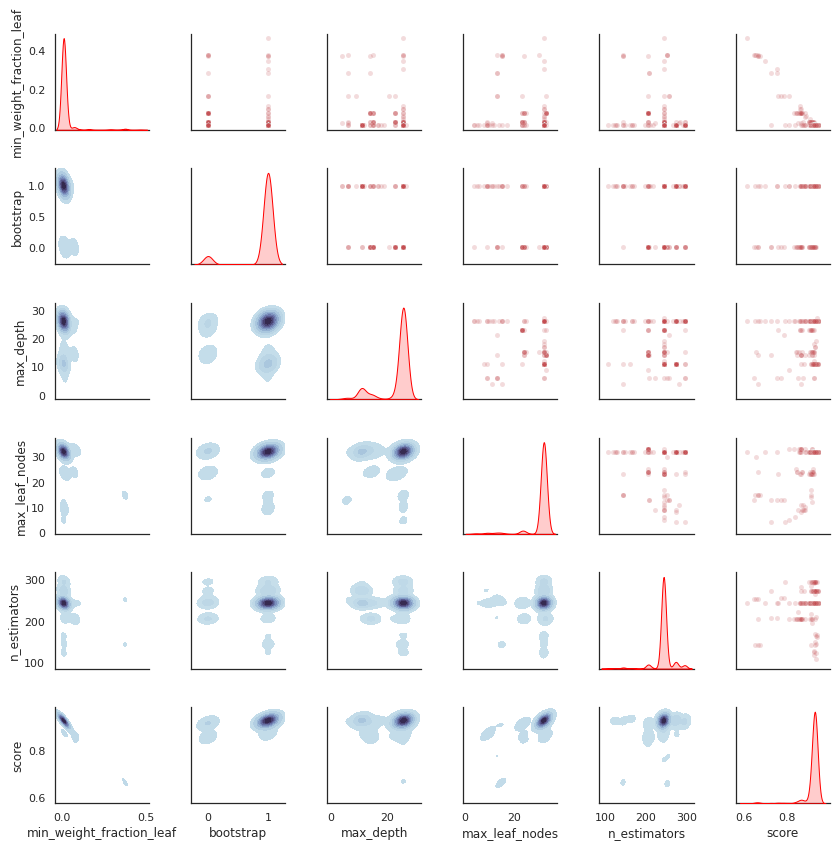

In [ ]:
plot_search_space(evolved_estimator)
plt.show()

In [ ]:
print("Best k solutions:") #k=4
evolved_estimator.hof

Best k solutions:


{0: {'min_weight_fraction_leaf': 0.012281015507535771,
  'bootstrap': True,
  'max_depth': 26,
  'max_leaf_nodes': 32,
  'n_estimators': 244},
 1: {'min_weight_fraction_leaf': 0.012281015507535771,
  'bootstrap': True,
  'max_depth': 11,
  'max_leaf_nodes': 32,
  'n_estimators': 274},
 2: {'min_weight_fraction_leaf': 0.012281015507535771,
  'bootstrap': True,
  'max_depth': 11,
  'max_leaf_nodes': 32,
  'n_estimators': 244},
 3: {'min_weight_fraction_leaf': 0.012281015507535771,
  'bootstrap': True,
  'max_depth': 27,
  'max_leaf_nodes': 32,
  'n_estimators': 244}}

##Phụ lục 1: Space definition
Định nghĩa không gian tìm kiếm với tham số `‘param_grid’`; nó cần một từ điển với một số lớp sau:

Categorical: Đại diện cho các biến phân loại, kỳ vọng một danh sách các tùy chọn mà nó có thể lấy mẫu và tùy chọn xác suất lấy mẫu mỗi tùy chọn

Integer: Đại diện cho các biến số nguyên, kỳ vọng giới hạn trên và dưới của biến

Continuous: Đại diện cho các biến có giá trị thực, kỳ vọng giới hạn dưới và trên của biến, có thể tùy chọn lấy mẫu các giá trị từ phân phối log-uniform nếu biến được xác định dương.

##Phụ lục 2: các thông số của GASearchCV
population: số lượng ứng cử viên siêu tham số ban đầu cần khởi tạo ngẫu nhiên.

generations: Thuật toán sẽ thực hiện bao nhiêu lần lặp, nó tạo ra một quần thể mới sau mỗi thế hệ

elitism: Nếu đúng (True), nó sử dụng một giải đấu chọn lựa để giữ k cá thể tốt nhất; nếu sai (False), nó sử dụng cơ chế lựa chọn roulette.

tournament size: Số lượng cá thể để tiến hành giải đấu lựa chọn, chỉ được sử dụng nếu elitism = True.

crossover_probability: Xác suất xảy ra sự lai chéo trong một lần lai ghép cụ thể.

mut_probability: Xác suất mà một cá thể đã cố định, bị đột biến ngẫu nhiên trong một số giá trị siêu tham số của nó.

param_grid: từ điển với các khóa là tên của các siêu tham số và các giá trị là một trong số các kiểu được định nghĩa trong không gian tìm kiếm  Categorical, Continuous hoặc Integer từ sklearn_genetic.space

Xác định các giá trị có thể mà tham số này có thể nhận.

criteria: "max" nếu độ đo "scoring" được chọn, độ đo này được coi là tốt hơn khi giá trị của nó tăng lên, ngược lại là "min".

algorithm: Thuật toán tiến hóa cụ thể từ gói được sử dụng, phiên bản 0.5.0 của sklearn-gene-opt hỗ trợ eaSimple, eaMuPlusLambda và eaMuCommaLambda.

n_jobs: Có bao nhiêu công việc đồng thời để khởi chạy qua bước xác thực chéo

verbose: Nếu Đúng (True), nó hiển thị một số chỉ số về việc tối ưu hóa trong khi thuật toán chạy.

keep_top_k: Dựa trên điểm xác thực chéo cuối cùng của nó, có bao nhiêu bộ siêu tham số sẽ trả về khi kết thúc tối ưu hóa. Tham số này xác định kích thước của hof.

log_config: Nếu bạn đặt tham số này với MLflowConfig, các chỉ số, siêu tham số và mô hình sẽ được ghi vào máy chủ MLflow.